In [32]:
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

import glob
import dask
import warnings
import cartopy
import pickle

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import sys
sys.path.insert(0, "/user/work/eh19374/LPDM-emulation-trees_TESTING/")
from trees_emulator.load_data import *
from trees_emulator.training import *
from trees_emulator.predicting import *
from trees_emulator.marco_functions import *

import warnings
warnings.filterwarnings('ignore')

In [33]:
# run this so loaded functions/packages get automatically updated if you edit
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading Datasets

In [3]:
# load the data for a particular site
site = "MHD"

domains = {"MHD":"EUROPE", "THD":"USA", "TAC":"EUROPE", "RGL":"EUROPE", "HFD":"EUROPE", "BSD":"EUROPE", "GSN":"EASTASIA"}
heights = {"MHD":"10magl", "THD":"10magl", "TAC":"185magl", "RGL":"90magl", "HFD":"100magl", "BSD":"250magl", "GSN":"10magl"} # default heights

## for UK/Ireland sites (MHD, TAC, RGL, BSD, HFD)
met_datadir = "/group/chemistry/acrg/met_archive/NAME/EUROPE_met/EUROPE_Met_10magl_*"
fp_datadir = f"/group/chemistry/acrg/LPDM/fp_NAME/EUROPE/{site}-{heights[site]}_UKV_EUROPE_*"
extramet_datadir = "/group/chemistry/acrg/met_archive/NAME/full_extra_vars/EUROPE*"
## for GSN (South Korea)
# met_datadir = "/group/chemistry/acrg/met_archive/NAME/other_met/EASTASIA_Met_*"
# fp_datadir = "/group/chemistry/acrg/LPDM/fp_Elena/EASTASIA/GSN_*"
# extramet_datadir = "/group/chemistry/acrg/met_archive/NAME/full_extra_vars/EASTASIA*"

## for THD (California)
# met_datadir = "/group/chemistry/acrg/met_archive/NAME/other_met/USA_Met_*" # for TAC
# fp_datadir = "/group/chemistry/acrg/LPDM/fp_Elena/USA/THD_*"
# extramet_datadir = "/group/chemistry/acrg/met_archive/NAME/full_extra_vars/USA*"


data_201415_coarse2 = LoadData(year="201[4-5]", site=site, size=9, coarsen_factor=2, verbose=True, met_datadir=met_datadir, fp_datadir=fp_datadir, extramet_datadir=extramet_datadir)
data_2016_coarse2 = LoadData(year="2016", site=site, size=9, coarsen_factor=2, verbose=True, met_datadir=met_datadir, fp_datadir=fp_datadir, extramet_datadir=extramet_datadir)
data_2016_coarse3 = LoadData(year="2016", site=site, size=12, coarsen_factor=3, verbose=True, met_datadir=met_datadir, fp_datadir=fp_datadir, extramet_datadir=extramet_datadir)
data_2016_coarse4 = LoadData(year="2016", site=site, size=17, coarsen_factor=4, verbose=True, met_datadir=met_datadir, fp_datadir=fp_datadir, extramet_datadir=extramet_datadir)
data_2016_coarse5 = LoadData(year="2016", site=site, size=24, coarsen_factor=5, verbose=True, met_datadir=met_datadir, fp_datadir=fp_datadir, extramet_datadir=extramet_datadir)

data_2016 = LoadData(year="2016", site=site, verbose=True, met_datadir=met_datadir, fp_datadir=fp_datadir, extramet_datadir=extramet_datadir)
data_2016_20 = LoadData(year="2016", site=site, size=20, verbose=True, met_datadir=met_datadir, fp_datadir=fp_datadir, extramet_datadir=extramet_datadir)

Loading Meteorology data from /group/chemistry/acrg/met_archive/NAME/EUROPE_met/EUROPE_Met_10magl_*201[4-5]*.nc
Loading footprint data from /group/chemistry/acrg/LPDM/fp_NAME/EUROPE/MHD-10magl_UKV_EUROPE_*201[4-5]*.nc
Cutting data to size
Loading extra meteorology from /group/chemistry/acrg/met_archive/NAME/full_extra_vars/EUROPE*201[4-5]*.nc and extracting gradients
temp_grad.values =  17520
temp_grad.time =  17520
metsize =  14
Extracting wind vectors
All data loaded
Loading Meteorology data from /group/chemistry/acrg/met_archive/NAME/EUROPE_met/EUROPE_Met_10magl_*2016*.nc
Loading footprint data from /group/chemistry/acrg/LPDM/fp_NAME/EUROPE/MHD-10magl_UKV_EUROPE_*2016*.nc
Cutting data to size
Loading extra meteorology from /group/chemistry/acrg/met_archive/NAME/full_extra_vars/EUROPE*2016*.nc and extracting gradients
temp_grad.values =  8784
temp_grad.time =  8784
metsize =  14
Extracting wind vectors
All data loaded
Loading Meteorology data from /group/chemistry/acrg/met_archive/NA

In [4]:
data_2016.fp_data_full

<xarray.Dataset>
Dimensions:               (time: 8784, lon: 391, lat: 293, lev: 1, height: 20)
Coordinates:
  * time                  (time) datetime64[ns] 2016-01-01 ... 2016-12-31T23:...
  * lon                   (lon) float32 -97.9 -97.55 -97.2 ... 38.68 39.03 39.38
  * lat                   (lat) float32 10.73 10.96 11.2 ... 78.59 78.82 79.06
  * lev                   (lev) |S1 b'F'
  * height                (height) float32 500.0 1.5e+03 ... 1.85e+04 1.95e+04
Data variables: (12/16)
    fp                    (lat, lon, time) float32 dask.array<chunksize=(293, 391, 744), meta=np.ndarray>
    temperature           (time) float32 dask.array<chunksize=(744,), meta=np.ndarray>
    pressure              (time) float32 dask.array<chunksize=(744,), meta=np.ndarray>
    wind_speed            (time) float32 dask.array<chunksize=(744,), meta=np.ndarray>
    wind_direction        (time) float32 dask.array<chunksize=(744,), meta=np.ndarray>
    PBLH                  (time) float32 dask.array<chunksize=(744,), meta=np.ndarray>
    ...                    ...
    particle_locations_s  (height, lon, time) float32 dask.array<chunksize=(20, 391, 744), meta=np.ndarray>
    particle_locations_w  (height, lat, time) float32 dask.array<chunksize=(20, 293, 744), meta=np.ndarray>
    mean_age_particles_n  (height, lon, time) float32 dask.array<chunksize=(20, 391, 744), meta=np.ndarray>
    mean_age_particles_e  (height, lat, time) float32 dask.array<chunksize=(20, 293, 744), meta=np.ndarray>
    mean_age_particles_s  (height, lon, time) float32 dask.array<chunksize=(20, 391, 744), meta=np.ndarray>
    mean_age_particles_w  (height, lat, time) float32 dask.array<chunksize=(20, 293, 744), meta=np.ndarray>
Attributes: (12/17)
    author:                   Met Office/University of Bristol
    contact:                  Alistair Manning
    file_created_by:          ag12733
    funder:                   BEIS
    public_acknowledgement:   Please acknowledge the Met Office/University of...
    fp_output_units:          ppms
    ...                       ...
    model_version:            NAME III (version 7.2)                         ...
    domain:                   EUROPE
    site:                     MHD
    inlet_height:             10magl
    ACRG_repository_version:  v0.2.0-22-gca6dc68
    created:                  2021-04-28 16:12:15.535541

Text(0.5, 1.0, 'Target Region for MHD')

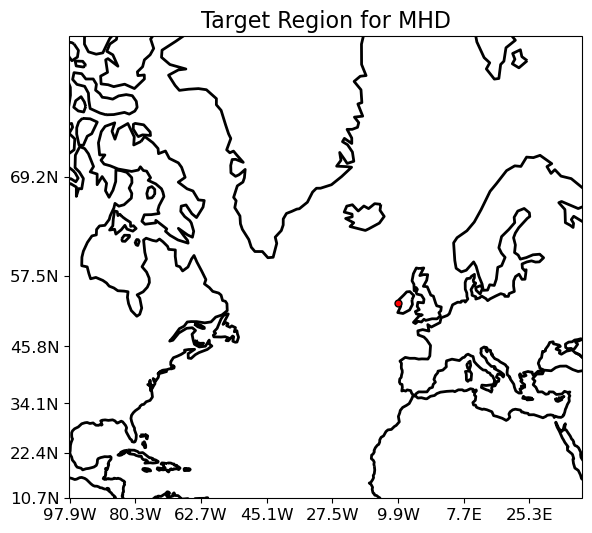

In [5]:
## create figure and plot
fig, ax = plt.subplots(1,1,figsize = (8,6), subplot_kw={'projection':cartopy.crs.Mercator()})
## axis
# set extent defines the domain to plot
ax.set_extent([data_2016.fp_data_full.lon[0]-0.1,data_2016.fp_data_full.lon[-1]+0.1, data_2016.fp_data_full.lat[0]+0.1,data_2016.fp_data_full.lat[-1]+0.1], crs=cartopy.crs.PlateCarree())
ax.set_xticks(data_2016.fp_data_full.lon[::50], crs=cartopy.crs.PlateCarree())

lon_formatter = LongitudeFormatter(number_format='.1f', degree_symbol='', dateline_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)  
ax.set_yticks(data_2016.fp_data_full.lat[::50], crs=cartopy.crs.PlateCarree())
lat_formatter = LatitudeFormatter(number_format='.1f',  degree_symbol='',)
ax.yaxis.set_major_formatter(lat_formatter)             
ax.tick_params(axis='both', which='major', labelsize=12)   

# marker for release point
ax.plot(data_2016.release_lon+0, data_2016.release_lat+0, marker='o', c="r", markeredgecolor = "k", transform=cartopy.crs.PlateCarree(), markersize=5)
# 50 or 110
ax.coastlines(resolution='110m', color='black', linewidth=2)
ax.set_title('Target Region for ' + data_2016.site, fontsize=16)

Text(0.5, 1.0, 'Black = Original\nWhite = 2x Coarsen')

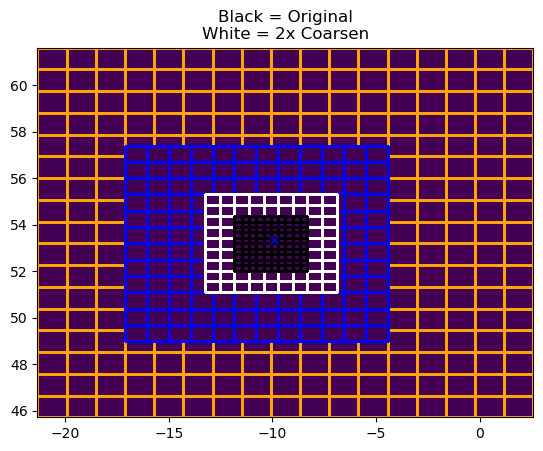

In [72]:
lonmesh_OG, latmesh_OG = np.meshgrid(data_2016.fp_lons, data_2016.fp_lats)
lonmesh_2, latmesh_2 = np.meshgrid(data_2016_coarse2.fp_lons, data_2016_coarse2.fp_lats)
lonmesh_3, latmesh_3 = np.meshgrid(data_2016_coarse3.fp_lons, data_2016_coarse3.fp_lats)
lonmesh_4, latmesh_4 = np.meshgrid(data_2016_coarse4.fp_lons, data_2016_coarse4.fp_lats)

fig, ax = plt.subplots(1,1)
ax.pcolormesh(lonmesh_4, latmesh_4, np.zeros_like(lonmesh_4), edgecolors='orange')
ax.pcolormesh(lonmesh_3, latmesh_3, np.zeros_like(lonmesh_3), edgecolors='blue')
ax.pcolormesh(lonmesh_2, latmesh_2, np.zeros_like(lonmesh_2), edgecolors='white')
ax.pcolormesh(lonmesh_OG, latmesh_OG, np.zeros_like(lonmesh_OG), edgecolors='black')
ax.plot(data_2016.release_lon, data_2016.release_lat, 'bx')
ax.set_title('Black = Original\nWhite = 2x Coarsen')

#### Loading original (no coarsening)

In [7]:
## variables that are passed at the time of the footprint and x hours before
vars_with_past = [data_2016.y_wind, data_2016.x_wind, data_2016.met.PBLH.values]
## variables that are only passed at the time of the footprint
vars_without_past = [data_2016.temp_grad, data_2016.x_wind_grad, data_2016.y_wind_grad]

inputs_16_OG = get_all_inputs_v3(vars_with_past, [6], vars_without_past, size=16)

# Load trained model. Info is a dict with general info about the training, clfs is a list of length size**2 with all regressors
with open(f'/group/chemistry/acrg/ef17148/trained_tree_models/{site}.txt', 'rb') as f:
    [info, clfs] = pickle.load(f)
print("Trained model info:", info)

predictionsOG = MakePredictions(clfs, data_2016, inputs_16_OG, 6)

Trained model info: {'site': {'MHD'}, 'training data': '201[4-5]', 'sampling frequency': 2, 'size': 10}


#### 2x Coarsened Model

In [8]:
coarse_predictions_2x_6h = import_coarsened_and_train('v3_MHD_1415_size9_coarsened2_hr6', data_2016_coarse2, [6], 14)

Trained model info: {'site': 'MHD', 'training data': '201[4-5]', 'sampling frequency': 2, 'size': 9}


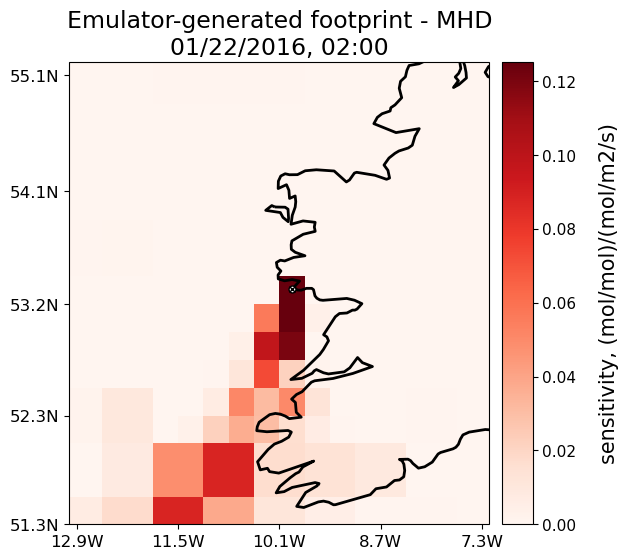

In [9]:
list_of_predictions = [coarse_predictions_2x_6h, predictionsOG]
plotting_coarsened(list_of_predictions, 500, 2)

Mean R2 external area = 0.3519


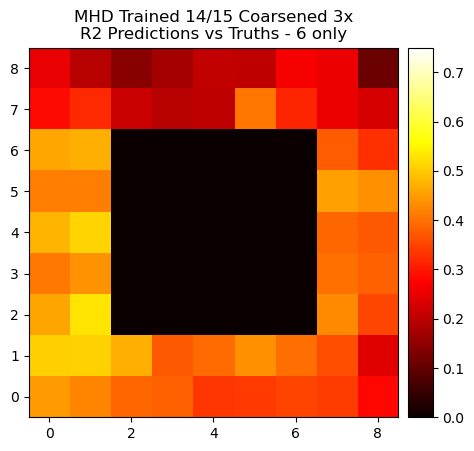

In [10]:
R_squared_plot(coarse_predictions_2x_6h, 2, '6 only', '14/15')

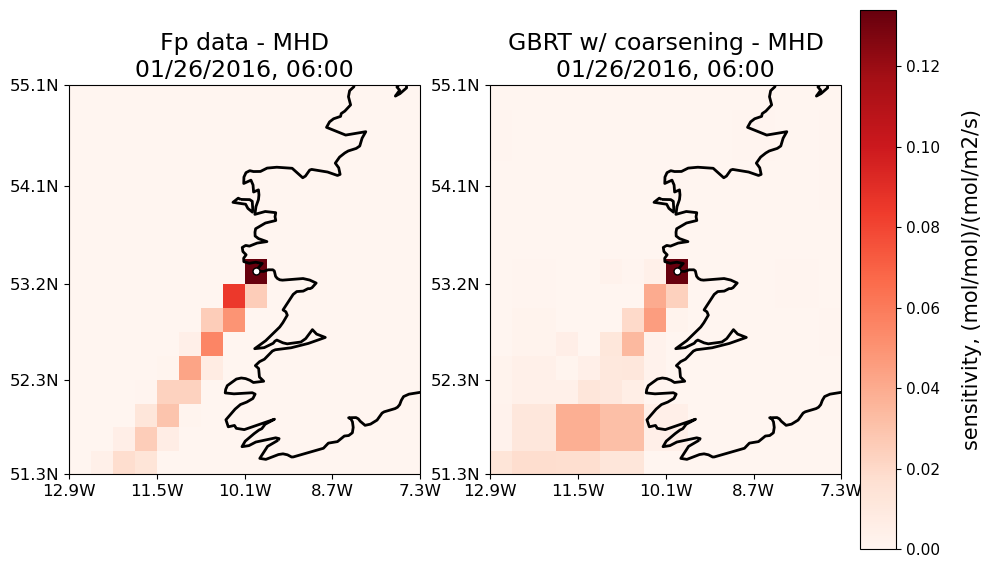

In [11]:
coarsened_vs_footprint(coarse_predictions_2x_6h, predictionsOG, data_2016_20, 600)

#### Coarsened 2x GIF 

In [12]:
make_footprint_gif_v2(coarse_predictions_2x_6h, predictionsOG, data_2016_20, 500, 600)

saving as  footprints_02-22-01-2016_06-26-01-2016.gif


### 3x Coarsened Model

In [13]:
coarse_predictions_3x_6h = import_coarsened_and_train('v3_MHD_1415_size12_coarsened3_hr6', data_2016_coarse3, [6], 18)


Trained model info: {'site': 'MHD', 'training data': '201[4-5]', 'sampling frequency': 2, 'size': 12}


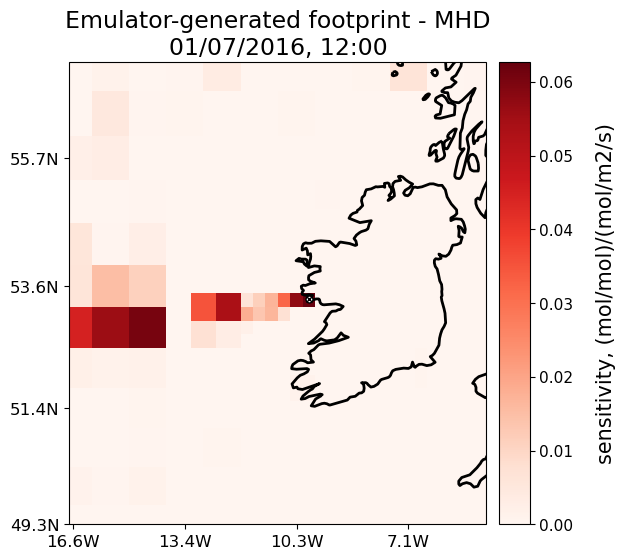

In [54]:
list_of_predictions = [coarse_predictions_3x_6h, coarse_predictions_2x_6h, predictionsOG]

plotting_coarsened(list_of_predictions, 150, 3)

Mean R2 external area = 0.1815


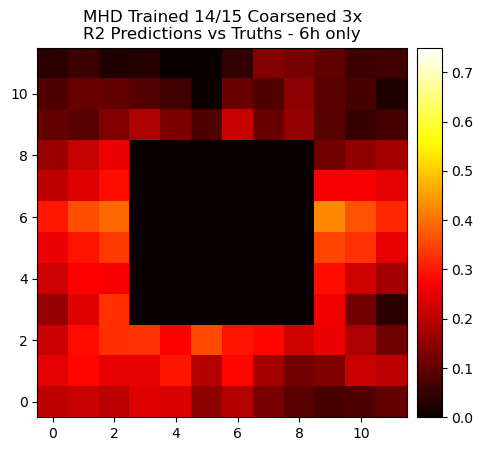

In [15]:
R_squared_plot(coarse_predictions_3x_6h, 3, '6h only', '14/15')

### 4x Coarsened Model

In [16]:
coarse_predictions_4x_6h = import_coarsened_and_train('v3_MHD_1415_size17_coarsened4_hr6', data_2016_coarse4, [6], 22)

Trained model info: {'site': 'MHD', 'training data': '201[4-5]', 'sampling frequency': 2, 'size': 17}


Mean R2 external area = 0.0747


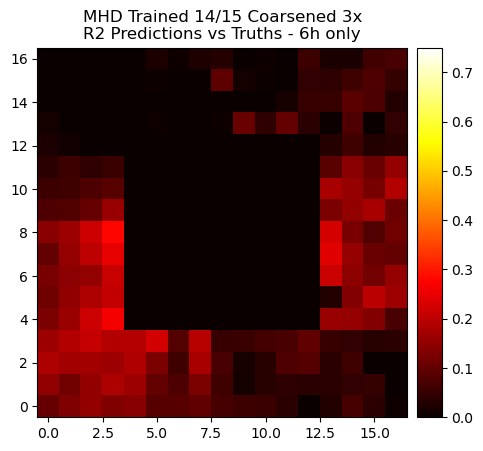

In [17]:
R_squared_plot(coarse_predictions_4x_6h, 4, '6h only', '14/15')

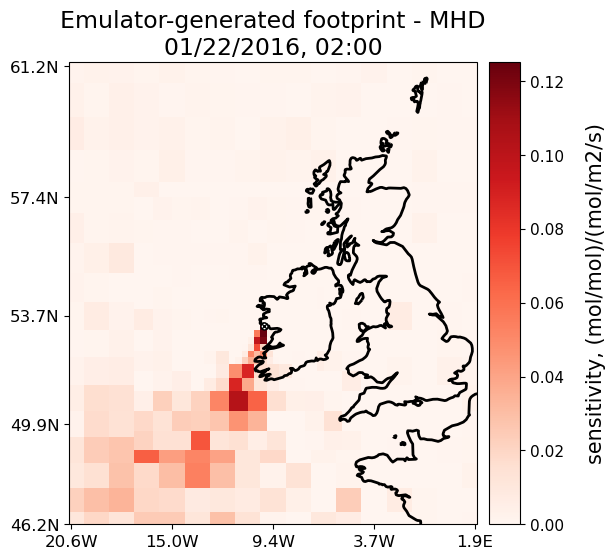

In [18]:
list_of_predictions = [coarse_predictions_4x_6h, coarse_predictions_3x_6h, coarse_predictions_2x_6h, predictionsOG]

plotting_coarsened(list_of_predictions, 500, 4)

#### 8x Testing
- 4x timings showed little to no effect of adding additional or changing the hours back
  - Assumed to be the error on the data is so large that the additional timings make no effect
- Testing 8x to fill out domain
  - still testing the timings just to be sure, 6, 12, 18, 24, 48 & 72h.
  - 26x26 area

### Next
- Using pred_fluxes
  - array of 1s as input in size required
- Dice & IoU
  - both give arrays for testing against FP data, alterations required for using with coarsened datasets
  - Dice needs binary value set, play around

Trained model info: {'site': 'MHD', 'training data': '201[4-5]', 'sampling frequency': 2, 'size': 24}
Mean R2 external area = 0.0555


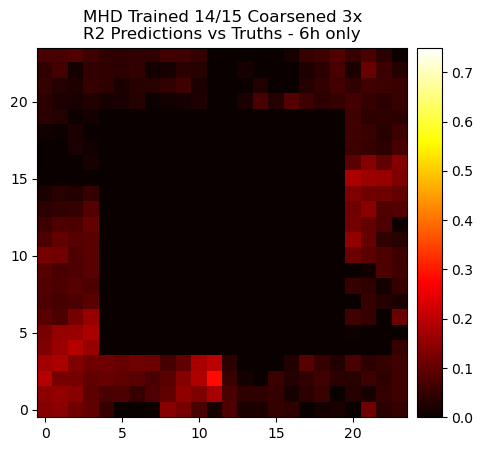

In [21]:
coarse_predictions_5x_6h = import_coarsened_and_train('v3_MHD_1415_size24_coarsened5_hr6', data_2016_coarse5, [6], 30)
R_squared_plot(coarse_predictions_5x_6h, 4, '6h only', '14/15')


In [22]:
# 8x, 16 = 0.0759

Text(0.5, 1.0, '5x, 4x, 3x, 2x & OG')

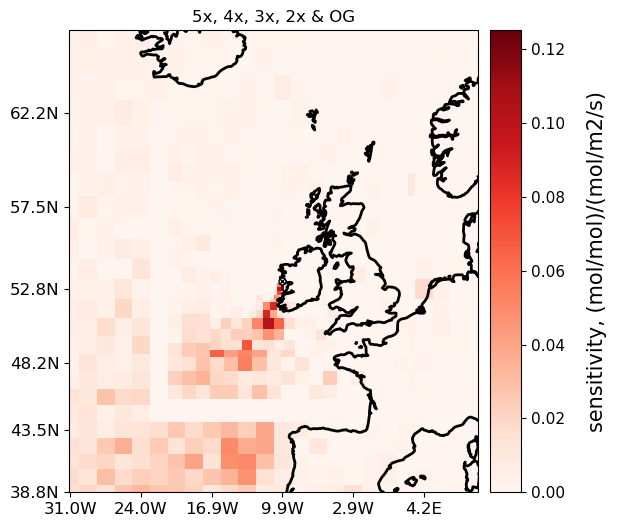

In [45]:
list_of_predictions = [coarse_predictions_5x_6h, coarse_predictions_4x_6h, coarse_predictions_3x_6h, coarse_predictions_2x_6h, predictionsOG]

plotting_coarsened(list_of_predictions, 500, 4)
plt.title("5x, 4x, 3x, 2x & OG")

In [24]:
## code here for setting a threshold for binary-izing the FP and predictions

In [25]:
def intersection_over_union(fps, preds, zero=-1):
    assert (np.unique(fps) == np.array([zero,1])).all(), "pass binary footprints, or if they arent -1/1, pass parameter zero="
    assert len(np.shape(fps))<=2, "currently this only supports flattened arrays (of shape (samples x pixels))"
    intersection = np.sum(np.logical_and(fps==1, preds==1, where=1), axis=-1)
    union = np.sum(np.logical_or(fps==1, preds==1, where=1), axis=-1)
    IoU = intersection/union
    return IoU


def dice_similarity(fps, preds, zero=-1):
    assert (np.unique(fps) == np.array([zero,1])).all(), "pass binary footprints, or if they arent -1/1, pass parameter zero="
    assert len(np.shape(fps))<=2, "currently this only supports flattened arrays (of shape (samples x pixels))"
    TP = np.sum(np.logical_and(fps==1, preds==1), axis=-1) 
    FP = np.sum(np.logical_and(fps==zero, preds==1), axis=-1) 
    FN = np.sum(np.logical_and(fps==1, preds==zero), axis=-1)
    dice = 2*TP/(2*TP + FP + FN)
    return dice

In [26]:
## inputs for above are time x flattened pixels etc.

In [27]:
extramet = xr.open_mfdataset(sorted(glob.glob(extramet_datadir)), combine='by_coords')

In [28]:
extramet.latitude

<xarray.DataArray 'latitude' (latitude: 73)>
array([43.957, 44.191, 44.425, 44.659, 44.893, 45.127, 45.361, 45.595, 45.829,
       46.063, 46.297, 46.531, 46.765, 46.999, 47.233, 47.467, 47.701, 47.935,
       48.169, 48.403, 48.637, 48.871, 49.105, 49.339, 49.573, 49.807, 50.041,
       50.275, 50.509, 50.743, 50.977, 51.211, 51.445, 51.679, 51.913, 52.147,
       52.381, 52.615, 52.849, 53.083, 53.317, 53.551, 53.785, 54.019, 54.253,
       54.487, 54.721, 54.955, 55.189, 55.423, 55.657, 55.891, 56.125, 56.593,
       56.827, 57.061, 57.295, 57.529, 57.763, 57.997, 58.231, 58.465, 58.699,
       58.933, 59.167, 59.401, 59.635, 59.869, 60.103, 60.337, 60.571, 60.805,
       61.039])
Coordinates:
  * latitude  (latitude) float64 43.96 44.19 44.42 44.66 ... 60.57 60.8 61.04
Attributes:
    axis:           Y
    units:          degrees_north
    standard_name:  latitude

In [29]:
extramet.longitude

<xarray.DataArray 'longitude' (longitude: 91)>
array([-20.46 , -20.108, -19.756, -19.404, -19.052, -18.7  , -18.348, -17.996,
       -17.644, -17.292, -16.94 , -16.588, -16.236, -15.884, -15.532, -15.18 ,
       -14.828, -14.476, -14.124, -13.772, -13.42 , -13.068, -12.716, -12.364,
       -12.012, -11.66 , -11.308, -10.956, -10.604, -10.252,  -9.9  ,  -9.548,
        -9.196,  -8.844,  -8.492,  -8.14 ,  -7.788,  -7.436,  -7.084,  -6.732,
        -6.38 ,  -6.028,  -5.676,  -5.324,  -4.972,  -4.62 ,  -4.268,  -3.916,
        -3.564,  -3.212,  -2.86 ,  -2.508,  -2.156,  -1.804,  -1.452,  -1.1  ,
        -0.748,  -0.396,  -0.044,   0.308,   0.66 ,   1.012,   1.364,   1.716,
         2.068,   2.42 ,   2.772,   3.124,   3.476,   3.828,   4.18 ,   4.532,
         4.884,   5.236,   5.588,   5.94 ,   6.292,   6.644,   6.996,   7.348,
         7.7  ,   8.052,   8.404,   8.756,   9.108,   9.46 ,   9.812,  10.164,
        10.516,  10.868,  11.22 ])
Coordinates:
  * longitude  (longitude) float64 -20.46 -20.11 -19.76 ... 10.52 10.87 11.22
Attributes:
    axis:           X
    units:          degrees_east
    standard_name:  longitude

In [69]:
def test_find_center_indexes(grid_size, border_width):
    center_indexes = find_center_indexes(grid_size, border_width)

    # Create a 2D array with all values set to 1
    data = np.ones(grid_size**2)

    # Set the values at the center_indexes to 0
    data[center_indexes] = 0

    data = np.reshape(data, (grid_size,grid_size))
    # Create a colormesh plot of the data
    plt.figure()
    plt.imshow(data, cmap="gray", origin='lower')
    plt.colorbar()
    plt.title("Center Indexes")
    plt.show()

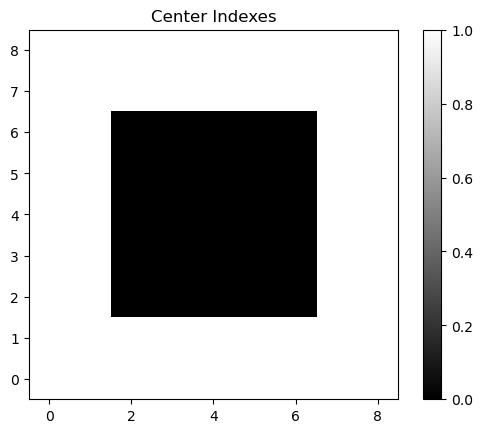

In [70]:
test_find_center_indexes(9,2)